#CS741: Assignment 2: Exact Inference in Trees and Graphs
## Dr. Hennie de Villiers - Computer Science - Stellenbosch University

## Your name:
## Your student number:


Note: Part of this assignment was adapted from Prof. Johan du Preez at Electronic Engineering

## Please note, this is the preliminary assignment, I will inform you of any changes to this by the end of the week. (This may include extra questions towards the end of the assignment, but the first portion should stay more or less the same)

## Introduction

This assignment builds on your previous assignment. At very least, you should have completed the `infer` method, because you will use this as a component of your inference (we will be using Shafer-Shenoy message passing, which is basically `infer` being used on subportions of the joint distribution, rather than the entire joint distribution). We start by declaring every utility function from the last assignment, note that you have to fill in your version of the `infer` method. Also note that we are changing all occurences of `cpd` in identifiers to `factor`, because that is actually more correct when we are dealing with general graphical models.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import pydot
from IPython.display import SVG

import theano
import theano.tensor as T

import operator

## The Burglar Network: Setting up variables and factors

As in the previous assignment, you will use the Burglar network to test out your code. In this section, we just repeat the definitions we used in the previous assignment. In the subsequent section, you will implement the portions of code needed to represent the Burglar network as a cluster graph. So, if you finished the first assignment, you can safely skip the current section (it is repeated here for clarity), and move on to the subsequent section.

We are now going to learn more about multidimensional arrays (tensors) in Theano by implementing some basic inference tasks. Consider representing the conditional probability $P(A|B,E)$ from the "Alarm" problem from Chapter 3. The Numpy array representing this is given by:

In [2]:
p_a_given_be = np.zeros((2,2,2),dtype=theano.config.floatX)
p_a_given_be[1,0,0] = 0.0001 # P(A=1|B=0,E=0)
p_a_given_be[1,0,1] = 0.99 # P(A=1|B=0,E=0)
p_a_given_be[1,1,0] = 0.99 # P(A=1|B=0,E=0)
p_a_given_be[1,1,1] = 0.9999 # P(A=1|B=0,E=0)
p_a_given_be[0,:,:] = 1 - p_a_given_be[1,:,:]

Similarly, $P(R|E)$, $P(E)$ and $P(B)$ are given by

In [3]:
p_r_given_e = np.zeros((2,2),dtype=theano.config.floatX)
p_r_given_e[1,0] = 0.0
p_r_given_e[1,1] = 1.0
p_r_given_e[0,:] = 1 - p_r_given_e[1,:]

p_e = np.zeros((2,),dtype=theano.config.floatX)
p_e[1] = 0.000001
p_e[0] = 1 - p_e[1]

p_b = np.zeros((2,),dtype=theano.config.floatX)
p_b[1] = 0.01
p_b[0] = 1 - p_b[1]

Now, we can define state variables for each of the alarm problem's variables. They are 64-bit integer scalars, so we use the `T.lscalar` constructor (`l` for `long`). Note we do something different here from last time. For each variable, we keep track of its theano variable, and its domain size.

In [4]:
def make_variable(name, domain_size):
    return (T.lscalar(name), domain_size)

def theano_variable(variable):
    return variable[0]

def domain_size(variable):
    return variable[1]

alarm = make_variable("A", 2)
burglar = make_variable("B", 2)
earthquake = make_variable("E", 2)
radio = make_variable("R", 2)

Similar to variables, we do bookkeeping for factors as well. We keep both the potential table, as well as the variables that are bound to it. Note that, for efficiency, sometimes you would want to share a potential table between different potentials (which you can do by passing the same table to `make_factor`), but this isn't important for this particular tutorial.

In [5]:
def make_factor(potential_table, bound_variables):
    #pot_shape = tuple(potential_table.shape.eval())
    bound_variable_shape = tuple([domain_size(v) for v in bound_variables])
    #assert(pot_shape == bound_variable_shape)
    
    return (potential_table, tuple(bound_variables))

def factor_table(factor):
    return factor[0]

def factor_variables(factor):
    return factor[1]

def factor_shape(factor):
    return tuple([domain_size(f) for f in factor_shape])

alarm_factor = make_factor(theano.shared(p_a_given_be), (alarm, burglar, earthquake))
radio_factor = make_factor(theano.shared(p_r_given_e), (radio, earthquake))
burglar_factor = make_factor(theano.shared(p_b), (burglar,))
earthquake_factor = make_factor(theano.shared(p_e), (earthquake,))

## Question 1: Shafer-Shenoy get burgled

Your `infer` method from the previous assignment can actually be used as the foundation for performing Shafer-Shenoy message passing on an arbitrary cluster graph/tree. Let us begin by applying Shafer-Shenoy message passing on the burglar network. One cluster tree corresponding to Burglar network has two cluster, one with variables $A,B,E$, the other with variables $E,R$. The sepset between the two variable clusters contains just $E$ (this is the intersection of the two cluster variable sets). Below we draw the cluster graph using the `pydot` package:

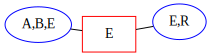

In [6]:
def draw_cluster_graph(cluster_labels, sepset_labels, sepset_connections):
    cluster_dot = pydot.Dot()
    cluster_dot.set_type("graph")
    clusters = [pydot.Node("c" + str(n)) for n in range(len(cluster_labels))]
    for n, c in enumerate(clusters):
        clusters[n].set_label(cluster_labels[n])
        clusters[n].set_color("blue")
        cluster_dot.add_node(clusters[n])
    sepsets = [pydot.Node("s" + str(n)) for n in range(len(sepset_labels))]
    for n, c in enumerate(sepsets):
        sepsets[n].set_label(sepset_labels[n])
        sepsets[n].set_color("red")
        sepsets[n].set_shape("rectangle")
        cluster_dot.add_node(sepsets[n])
    for n, c in enumerate(sepset_connections):
        c1, c2 = c
        cluster_dot.add_edge(pydot.Edge(clusters[c1], sepsets[n]))
        cluster_dot.add_edge(pydot.Edge(clusters[c2], sepsets[n]))
    return SVG(cluster_dot.create_svg(prog='neato'))
        
draw_cluster_graph(["A\,B\,E","E\,R"],["E"],[(0,1)] )

But, for trying out Shafer-Shenoy propagation, we should make the graph more complex. Another, less efficient, but valid, cluster graph is given by:

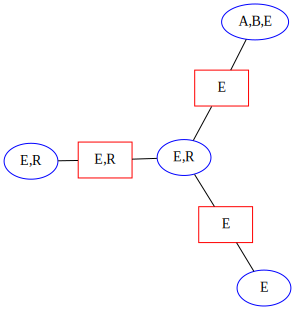

In [7]:
draw_cluster_graph(["A\,B\,E","E\,R","E","E\,R"],["E","E","E\,R"],[(0,1),(1,2),(1,3)] )

Note this is still a tree, so we can perform exact inference, only the central node now receives three messages, and there is one sepset with multiple variables along it. Suppose we attach the potentials $p(A|B,E)$ (`alarm_factor`) and $P(B)$ (`burglar_factor`) to the $A,B,E$ cluster, the potential $p(E)$ (`earthquake_factor`) to the $E$ cluster, and the $P(R|E)$ (`radio_factor`) to the outer $E,R$ cluster. Use your `infer` method from the last assignment to calculate the messages in both directions. 

For Shafer-Shenoy progagation, the rule for calculating a message over a sepset to another node, is that we multiply all the incoming messages to the source node (except the one coming in over the sepset we are currently considering) with any potentials at that node, and marginalize out any variables that are not in the sepset. Note that sometimes there may not be any other incoming messages at the source (this is true of leaf nodes), or there may not be a potential attached to a given node (in the above graph, this is true of the central node). In such cases, we simply multiply by $1$ as a placeholder.

We can calculate the message going the $E$ node using the following calls to `infer`.

In [9]:
def factor_reorder(factor, final_var_order):
    table = factor_table(factor)
    current_var_order = factor_variables(factor)
    ordering = []
    for v in final_var_order:
        try:
            idx = current_var_order.index(v)
            ordering.append(idx)
        except ValueError:
            ordering.append("x")
    return make_factor(table.dimshuffle(ordering), final_var_order)

def factor_product(factors, final_var_order):
    final_shape = tuple([domain_size(v) for v in final_var_order])
    ones = make_factor(T.ones(final_shape, theano.config.floatX), final_var_order)
    reordered = [factor_reorder(factor, final_var_order) for factor in factors]
    final_factors = [ones] + reordered
    final_tables = [factor_table(f) for f in final_factors]
    return make_factor(reduce(operator.mul, final_tables), final_var_order)

def factor_marginalize(factor, marginalize_out):
    bound_variables = factor_variables(factor)
    axes_to_sum = [bound_variables.index(v) for v in marginalize_out]
    final_vars = []
    marginalize_set = set(marginalize_out)
    for f in factor_variables(factor):
        if (f not in marginalize_set):
            final_vars.append(f)
    return make_factor(T.sum(factor_table(factor),axis=axes_to_sum), final_vars) 

def factor_normalize(factor):
    table = factor_table(factor)
    return make_factor(table / T.sum(table), factor_variables(factor))

def calc_message(source_factors, source_other_incoming_messages, sepset_vars):
    assert(isinstance(source_factors,list))
    assert(isinstance(source_other_incoming_messages,list))
    assert(isinstance(sepset_vars,list))
    # Collect all the factors at the node, as well as the incoming messages
    
    # Determine which variables must be marginalized over (so that just the sepset variables remain)
    
    # Reorder the variables, similar to the way you did for infer in the last tutorial.
    
    # Form the product of all the relevant factors and messages.
    
    # Marginalize out the dropped variables
    
    # Normalize the resulting message and return it
    return None

def calc_marginal(node_factors, incoming_messages, marginal_vars):
    assert(isinstance(node_factors,list))
    assert(isinstance(incoming_messages,list))
    assert(isinstance(marginal_vars,list))
    # Given the factors at the node, ALL the incoming messages, and the variables you'd like in the marginal,
    # return the maginal. This should be just one line of code.
    return None


# calc-message does not allow explicit conditioning. Instead, we will fake this potentials that are zero everywhere
# except at the constant value of the given variable. 
def conditioning_factor(conditioned_variable, value):
    table = np.zeros((domain_size(conditioned_variable),), dtype = theano.config.floatX)
    table[value] = 1.0
    table = theano.shared(table)
    return make_factor(table, (conditioned_variable,))
    
def recondition(conditioning_factor, new_value):
    conditioned_variable = factor_variables(conditioning_factor)[0]
    table = np.zeros((domain_size(conditioned_variable),), dtype = theano.config.floatX)
    table[new_value] = 1.0
    theano_table = factor_table(conditioning_factor)
    theano_table.set_value(table)

def reset_condition(conditioning_factor):
    conditioned_variable = factor_variables(conditioning_factor)[0]
    table = np.ones((domain_size(conditioned_variable),), dtype = theano.config.floatX) / domain_size(conditioned_variable)
    theano_table = factor_table(conditioning_factor)
    theano_table.set_value(table)

    
radio_conditioner = conditioning_factor(radio, 1)    
alarm_conditioner = conditioning_factor(alarm, 1)    

er_outer_factors = [radio_factor, radio_conditioner]
abe_factors = [alarm_factor, burglar_factor, alarm_conditioner]
er_inner_factors = []
e_factors = [earthquake_factor]

message_er_outer_to_er_inner = calc_message(er_outer_factors, [], [earthquake,radio])
message_abe_to_er_inner = calc_message(abe_factors, [], [earthquake])
message_er_inner_to_e = calc_message(er_inner_factors,[message_er_outer_to_er_inner, message_abe_to_er_inner], [earthquake])
marginal_at_e = calc_marginal(e_factors, [message_er_inner_to_e], [earthquake])

print "Case where Radio=1, Alarm=1"
print factor_table(message_er_outer_to_er_inner).eval()
print factor_table(message_abe_to_er_inner).eval()
print factor_table(message_er_inner_to_e).eval()
print factor_table(marginal_at_e).eval()

recondition(radio_conditioner, 0)
print "\nCase where Radio=0, Alarm=1"
print factor_table(message_er_outer_to_er_inner).eval()
print factor_table(message_abe_to_er_inner).eval()
print factor_table(message_er_inner_to_e).eval()
print factor_table(marginal_at_e).eval()

reset_condition(radio_conditioner)
print "\nCase where Alarm=1 (no knowledge of radio either way)"
print factor_table(message_er_outer_to_er_inner).eval()
print factor_table(message_abe_to_er_inner).eval()
print factor_table(message_er_inner_to_e).eval()
print factor_table(marginal_at_e).eval()

Case where Radio=1, Alarm=1


TypeError: 'NoneType' object has no attribute '__getitem__'

### Question: Now, calculate the messages needed to determine whether or not there is a burglar, and obtain the marginal over the Burglar variable.
* If the alarm has sounded, but we have no evidence regarding whether or not there was a radio report. Recall your answer will be about $p(B|A=1)\approx 0.99$.
* If the alarm has sounded and there is a radio report.  Recall your answer will be about $p(B=1|A=1,R=1)\approx 0.01$

Additional comments and investigation can be made here:

YOUR COMMENTS

## Question 2: Hamming Codes

### Background (from last assignment):
The Hamming $(7,4)$ code extends a 4 bit input sequence with a further 3 parity check bits to result in a 7 bit sequence to transmit. This provides redundancy that allows automatic correction of any one wrongly received bit. Figure 1 describes the coding stage of a Hamming $(7,4)$ code. 

![Encoder](encode.png)

The first four bits $b_1 \dots b_4$ represents the actual information we want to transmit. $\phi_{c_1} \dots \phi_{c_3}$ are the (even) parity checkers. Bits $b_5 \dots b_7$ are check bits to allow error correction – for a given $b_1\dots b_4$ we choose them to result in an even total parity for all the bits connected to a common $\phi_{c_i}$. For example, inputs $0111$ are transmitted as $0111010$. As an aside, note that if we should implement $\phi_{c_i}$, as potentials as we do for the decoding stage below, we can also unambiguously obtain $b_5 \dots b_7$ by finding its joint distribution given the observed $b_1 \dots b_4$.

![Decoder](decode.png)

Figure 2 is a factor graph describing the decoding process.  The sequence $r_1 \dots r_7$ describes the received
bits/signal values.  The variables $b_1 \dots b_7$ are the decoded binary bit sequence.  We can consider two cases:

- Hard decision: $r_1 \dots r_7$ are already binarised:  In this case the factors/potentials $\phi_{r_i}$ simply describe how likely it is that the received $r_i$ matches the transmitted $b_i$, i.e.  a discrete table giving
potentials for the four allocations of the variables $(r_i; b_i)$.
- Soft decision: $r_1 \dots r_7$ are the actual continuous pre-binarised received values:  In this case the
factors/potentials $\phi_{r_i}$ can be two (continuous) Gaussian pdfs for $r_i$ conditioned on whether the
transmitted value ($b_i$) was a zero or one.  The Gaussian means can be 0 and 1, while the standard
deviation for both cases can be set at 0.25.

The parity check factors/potentials $\phi_{c_i}$ takes on values zero or one based on whether its four inputs has
uneven or even parity.

### Background (new): Cluster graph

The *encoder* Markov network (the bottom part of the decoder network) is given by:

![Decoder Markov network](hamming_markov.png)

We can convert this into a Junction tree by using the variable elimination order $b_5$, $b_6$, $b_7$, $b_1$, $b_2$, $b_4$, $b_3$, which results in a cluster graph for the encoder network as below (verify this for yourself!):

![Encoder](hamming_cluster_graph.png)

Note that this is the *decoder* network (we have simply asses $r_n$ to the clusters at the top).

### Question 2.1

Apply the Shafer-Shenoy message passing you used in the previous question to the Junction Tree created here for the *HARD*-decoding case (assume a bit has a 5% chance of being mistransmitted). In other words, use a proper message-passing schedule that only sends a message when all the incoming messages it relies on are finalised. And do only one pass in each direction of each link. 
* Use this to calculate the marginals for each of the transmitted bits $b_n$, conditioned on the received bits $r_n$ (where $r_n$ is 0 or 1). 
* Assume that the values of $b_n$ that result in the maximum values at their marginals $p(b_n)$ are the transmitted bits, and determine whether this results in correct error correction in all cases where there is 0 or 1 error. Note that, in general, maximizing the marginals seperately is *NOT* equivalent to maximizing the joint. For that, we need to implement the max-product algorithm, but we will settle for this approximation here.

Hints: 
* First determine all the potentials in the problem. Define each of them.
* Then determine to which cluster each potential attaches.
* Message passing starts at the leaves, so work from there downwards, then back upwards once you've reached the bottom of the graph.
* Remember, you can introduce evidence using the conditioning factors. You can use this, as well as theano.function, to do the inference in one shot without rebuilding the network each time.
* Be careful on the upward pass towards the top nodes, since some of the downward messages are reused on this pass.

In [31]:
# Define your network here in a reusable format so that ...

In [ ]:
# ... in this block you can do your analysis, without having to have Theano rebuild the network each time. Use conditioning potentials for this!

### Question 2.2: Discussion
If the decoding does not successfully decode all cases with 0 or 1 error, why not? Can you motivate why the specific cases that fail follow from the junction tree and the potentials in question? If the decoding is perfect, discuss why the potentials and the junction tree structure imply this.

INSERT YOUR ANSWER HERE

### Additional comments

Add any additional comments or investigation you perform below.